**Install Featureform**


In [1]:
!pip3 install featureform
import featureform as ff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 616 kB/s 
     |████████████████████████████████| 407 kB 15.1 MB/s 
     |████████████████████████████████| 96 kB 4.0 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take int

**Download and register transaction file**

In [2]:
import requests
url = "https://featureform-demo-files.s3.amazonaws.com/transactions.csv"
r = requests.get(url)
open("transactions.csv" , 'wb').write(r.content)


--2022-08-09 00:40:03--  https://featureform-demo-files.s3.amazonaws.com/transactions.csv
Resolving featureform-demo-files.s3.amazonaws.com (featureform-demo-files.s3.amazonaws.com)... 52.216.200.171
Connecting to featureform-demo-files.s3.amazonaws.com (featureform-demo-files.s3.amazonaws.com)|52.216.200.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77027840 (73M) [text/csv]
Saving to: ‘transactions.csv’

transactions.csv    100%[===================>]  73.46M  31.8MB/s    in 2.3s    

2022-08-09 00:40:06 (31.8 MB/s) - ‘transactions.csv’ saved [77027840/77027840]



In [3]:
ff.register_user("Simba").make_default_owner()
local = ff.register_local()

transactions = local.register_file(
    name="transactions",
    variant="workshop",
    description="A dataset of fraudulent transactions",
    path="transactions.csv"
)
df = transactions.pandas()
df.head()

,TransactionID,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionAmount,Timestamp,IsFraud
0,T1,C5841053,10/1/94,JAMSHEDPUR,17819.05,25.0,2022-04-09 11:33:09,False
1,T2,C2142763,4/4/57,JHAJJAR,2270.69,27999.0,2022-03-27 01:04:21,False
2,T3,C4417068,26/11/96,MUMBAI,17874.44,459.0,2022-04-07 00:48:14,False
3,T4,C5342380,14/9/73,MUMBAI,866503.21,2060.0,2022-04-14 07:56:59,True
4,T5,C9031234,24/3/88,NAVI MUMBAI,6714.43,1762.5,2022-04-13 07:39:19,False


**Define and test a few transformations**

In [4]:
@local.df_transformation(variant="default", inputs=[transactions])
def average_user_transaction(transactions):
    """the average transaction amount for a user """
    return transactions.groupby("CustomerID")["TransactionAmount"].mean()

avg = average_user_transaction(df)
avg.head()

CustomerID
C1010011    2553.0
C1010012    1499.0
C1010014     727.5
C1010018      30.0
C1010024    5000.0
Name: TransactionAmount, dtype: float64

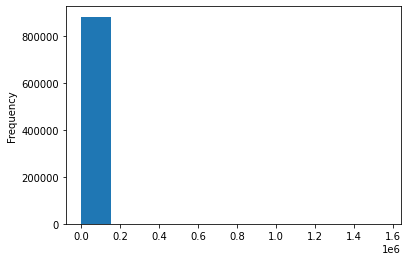

In [5]:
avg.plot(kind="hist")

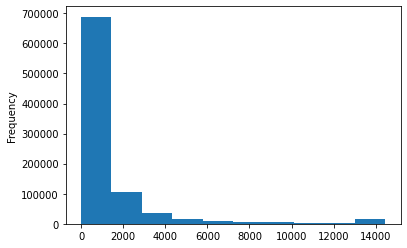

In [6]:
@local.df_transformation(variant="clipped",
                         inputs=[("average_user_transaction", "default")])
def average_user_transaction(transactions):
    """clip large transacton amounts """
    max = transactions.mean() + 2 * transactions.std()
    return transactions.clip(lower=0, upper=max)

average_user_transaction(avg).plot(kind="hist")

**Registering resources (Entity, feature, label)**

In [7]:
user = ff.register_entity("user")
# Register a column from our transformation as a feature
average_user_transaction.register_resources(
    entity=user,
    entity_column="CustomerID",
    inference_store=local,
    features=[
        {"name": "avg_transactions", "variant": "clipped", "column": "TransactionAmount", "type": "float32"},
    ],
)

# Register a label from our base Transactions table
transactions.register_resources(
    entity=user,
    entity_column="CustomerID",
    labels=[
        {"name": "fraudulent", "variant": "bool", "column": "IsFraud", "type": "bool"},
    ],
)

**Registering training set**

In [8]:
ff.register_training_set(
    "fraud_training", "simple",
    label=("fraudulent", "bool"),
    features=[("avg_transactions", "clipped")],
)


**Apply our definitions**

In [9]:
client = ff.ResourceClient(local=True)
client.apply()

Creating user Simba
Creating provider local mode
Creating source average_user_transaction
Creating source average_user_transaction
Creating entity user
Creating feature avg_transactions
Creating label fraudulent
Creating training-set fraud_training


**Train a Model**

In [10]:
serving = ff.ServingClient(local=True)
dataset = serving.training_set("fraud_training", "simple")
training_dataset = dataset.repeat(1).shuffle(1000).batch(12)

In [11]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log')
for batch in training_dataset:
  classifier.partial_fit(batch.features(), batch.label(), [True, False])

# Get one batch of training data as sample test data
# Make a test prediction
classifier.predict(batch.features())


AttributeError: ignored